In [34]:
import sympy as sm
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import math
from copy import deepcopy
import itertools

In [297]:
round_count = 2
cer = 10
eps = 1e-3
lam = 10
steps = 35

files = [
    'gpa-1.txt',
    'gpa-2.txt',
    'undetermine-system.txt'
]

values_gpa = {
    '1' : [
        ('p2', 10),
        ('p4', 10),
        ('q1', 4),
        ('q2', 4),
        ('q3', 4),
        ('q4', 4),
        ('q5', 4)
    ],
    '2': [
        ['p2', 160],
        ['q1', 60],
        ['q2', 50],
        ['q3', 50]
    ],
    '3': [
        ['p2', 160],
        ['p3', 100],
        ['q1', 60],
        ['q2', 50],
        ['q3', 50],
        ['q4', 10]
    ],
    '4':[
        ['p2', 160],
        ['p3', 100],
        ['p4', 100],
        ['q1', 60],
    ]
}

In [36]:
def cacl_jac(all_symbols=[], equations=[]):
    jacobi = sm.zeros(len(all_symbols), len(all_symbols))
    for var_i in range(len(all_symbols)):
        var = all_symbols[var_i]
        for eq_i in range(len(equations)):
            eq = equations[eq_i]
            jacobi[eq_i, var_i] = sm.diff(eq, var)
        
    jacobian = jacobi.det()
    
    return jacobi, jacobian

In [37]:
def disp_graph_with_custom_labels(gr=None, 
                                  nodes_labels={}, 
                                  edges_labels={},
                                  fig_size=8,
                                  node_label=None, 
                                  edge_label=None):
    plt.figure(figsize=(fig_size, fig_size))
    
    if not edge_label == None and not edge_label == '':
        edges_labels = nx.get_edge_attributes(G=gr, name=edge_label)
        
    if not node_label == None and not node_label == '':
        nodes_labels = nx.get_node_attributes(G=gr, name=node_label)

    layout = nx.shell_layout(gr)
    
    nx.draw(G=gr, pos=layout, node_size=1500)
    nx.draw_networkx_edge_labels(G=gr, 
                                 pos=layout, 
                                 edge_labels=edges_labels, 
                                 font_family='sans-serif')
    nx.draw_networkx_labels(G=gr, 
                            pos=layout, 
                            labels=nodes_labels, 
                            font_family='sans-serif')
    plt.show()

In [38]:
def subs_to_graph_new_values(gr=None, values=[]):
    q = nx.get_edge_attributes(G=gr, name='q')
    p = nx.get_node_attributes(G=gr, name='p')

    for sub_expr in values:
        sym = sub_expr[0]
        val = round(sub_expr[1], round_count)

        for edge_param in list(q.items()):
            if sym == str(edge_param[1]):
                q[edge_param[0]] = val

        for node_param in list(p.items()):
            if sym == str(node_param[1]):
                p[node_param[0]] = val

#     print(q)
#     print(p)

    nx.set_edge_attributes(G=gr, name='q', values=q)
    nx.set_node_attributes(G=gr, name='p', values=p)

In [39]:
def disp_graph(gr=None, edge_label='q',
               node_label='p',
               fig_size=8):
    
    plt.figure(figsize=(fig_size, fig_size))
    
    edges_labels = nx.get_edge_attributes(G=gr, 
                                          name=edge_label)
    nodes_labels = nx.get_node_attributes(G=gr, 
                                          name=node_label)
    
    layout = nx.shell_layout(gr)
    
    nx.draw(G=gr, pos=layout, 
            node_size=1500)
    nx.draw_networkx_edge_labels(G=gr, 
                                 pos=layout, 
                                 edge_labels=edges_labels, 
                                 font_family='sans-serif')
    nx.draw_networkx_labels(G=gr, 
                            pos=layout, 
                            labels=nodes_labels, 
                            font_family='sans-serif')
    plt.show()

In [669]:
def read_graph(path=''):
    all_symbols = []

    gpa = nx.DiGraph()

    with open(path, 'r') as input:
        line = input.readline()

        params = list(map(lambda x : int(x), 
                          line.split(' ')))
        V, E = params[0], params[1]

        graph_params = {
            'nodes' : dict(),
            'edges' : dict()
        }

        for i in range(V):
            params = list(map(lambda x : int(x), 
                              input.readline().split(' ')))
            node = int(params[0])

            if len(params) == 1:
                p_i = sm.symbols('p' + str(i + 1))
                known = False
                all_symbols.append(p_i)
            else:
                p_i = params[1]
                known = True
            gpa.add_node(node, 
                         p=p_i, 
                         known=known, 
                         known_q=True,
                         q=0,
                         influx=0,
                         code=str(i + 1),
                         var=sm.symbols('p' + str(i + 1)))

        for i in range(E):
            params = list(map(lambda x : int(x), 
                              input.readline().split(' ')))

            u = int(params[0])
            v = int(params[1])
            l = params[2]
            d = params[3]

            if len(params) == 4:
                q_i = sm.symbols('q' + str(i + 1))
                known = False
                all_symbols.append(q_i)
            else:
                q_i = params[4]
                known = True
            
#             print(v, q_i, gpa.nodes[v]['known_q'], gpa.nodes[v]['known_q'] and not isinstance(q_i, sm.Symbol))
#             print(u, q_i, gpa.nodes[u]['known_q'], gpa.nodes[u]['known_q'] and not isinstance(q_i, sm.Symbol))
            
            if not gpa.nodes[u]['q'] == 0:
                gpa.nodes[u]['q'] -= q_i
                gpa.nodes[u]['known_q'] = gpa.nodes[u]['known_q'] and not isinstance(q_i, sm.Symbol)
            else:
                gpa.nodes[u]['q'] = q_i
                gpa.nodes[u]['known_q'] = gpa.nodes[u]['known_q'] and not isinstance(q_i, sm.Symbol)
            
            if not gpa.nodes[v]['q'] == 0:
                gpa.nodes[v]['q'] -= q_i
                gpa.nodes[v]['known_q'] = gpa.nodes[v]['known_q'] and not isinstance(q_i, sm.Symbol)
            else:
                gpa.nodes[v]['q'] = q_i
                gpa.nodes[v]['known_q'] = gpa.nodes[v]['known_q'] and not isinstance(q_i, sm.Symbol)
            
            if u == 1:
                gpa.nodes[u]['influx'] += q_i
                gpa.nodes[u]['known_q'] = not isinstance(q_i, sm.Symbol)
                
            gpa.nodes[v]['influx'] += q_i
            gpa.nodes[v]['known_q'] = not isinstance(q_i, sm.Symbol)
            
            gpa.add_edge(u=u, 
                         v=v,
                         q=q_i, 
                         L=l, 
                         D=d, 
                         known=known, 
                         code=str(i + 1), 
                         var=sm.symbols('q' + str(i + 1)))
            
    return gpa, all_symbols

In [670]:
def get_equations(gr=None, all_symbols=[]):
    q = nx.get_edge_attributes(G=gr, name='q')
    p = nx.get_node_attributes(G=gr, name='p')
    l = nx.get_edge_attributes(G=gr, name='L')
    d = nx.get_edge_attributes(G=gr, name='D')
    
    equations = []

    for edge, param in q.items():
        qc = param
        pcs = p[edge[0]]
        pcf = p[edge[1]]
        dc = d[edge]
        lc = l[edge]

        counter = 0

        eq = pcs * pcs - pcf * pcf - qc * qc * lc * dc ** 5

        fl = True
        for sym in all_symbols:
            expr = sm.diff(eq, sym)
            fl = fl and expr == 0

        if not fl:
            equations.append(eq)

    edge_list = list(gr.edges())
    temp = np.zeros((len(edge_list), 2))
    for i in range(len(edge_list)):
        edge = edge_list[i]
        temp[i][0] = edge[0]
        temp[i][1] = edge[1]

    edges = temp

    for node in gr.nodes():

        eq = 0
        counter = 0
        for temp_edge in edges:
            if temp_edge[0] == node:
                qc = q[(temp_edge[0], temp_edge[1])]
                eq += qc
                counter += 1
            if temp_edge[1] == node:
                qc = q[(temp_edge[0], temp_edge[1])]
                eq -= qc
                counter += 1

        fl = True
        for sym in all_symbols:
            expr = sm.diff(eq, sym)
            fl = fl and expr == 0

        if not fl and counter > 1:
            equations.append(eq)

    for i in range(len(equations)):
        print('equation ' + 
              str(i + 1) + 
              ' : ' + 
              str(equations[i]))

    return equations

In [671]:
def get_newton_equations(equations=[], all_symbols=[]):
    jacobi, jacobian = cacl_jac(all_symbols=all_symbols, 
                                equations=equations)
    
    eqs = []
    eq = sm.Matrix(deepcopy(equations))
    
    for i in range(len(all_symbols)):
        f_i = deepcopy(jacobi)
        f_i[:, i] = eq
        
        f_i = f_i.det()
        f_i = f_i / jacobian

        
        eqs.append(sm.simplify(f_i))
        
    return eqs

In [672]:
def subs(values=[], eqs=[]):
    ans = [float(eq.subs(values)) 
           for eq in eqs]
    
    return ans

In [673]:
def partial_subs(values=[], eqs=[]):  
    ans = [eq.subs(values) for eq in eqs]
    
    return ans

In [674]:
def solving(values=[], eqs=[], steps=25, eps=0.001):
    cer = 1
    ers = []

    while cer > eps and steps > 0:
        er = []
        
        try:
            
            nv = []

            ans = subs(eqs=eqs, values=values)

            for i in range(len(values)):
                val = values[i][1] - ans[i]
                sym = values[i][0]

                nv.append((sym, val))
                er.append(math.fabs(ans[i]))

            values = nv    

            er = np.linalg.norm(np.array(er))
            ers.append(er)
            cer = er

            steps -= 1

        except Exception as ex:
            break
    
    return values, ers

# Реализация метода Ньютона

In [675]:
def calc(path='', values=[]):
    gpa, all_symbols = read_graph(path=path)
    
#     disp_graph_with_custom_labels(gr=gpa, 
#                                   edge_label='q', 
#                                   node_label='p')
    
    equations = get_equations(gr=gpa, 
                              all_symbols=all_symbols)
    
    print()
    print('Переменных :', len(all_symbols), all_symbols)
    print('Уравнений :', len(equations))
    print()
    
    eqs = get_newton_equations(all_symbols=all_symbols, 
                               equations=equations)
    
    values, ers = solving(values=values, eqs=eqs)

    subs_to_graph_new_values(values=values, gr=gpa)
#     disp_graph(gr=gpa, edge_label='q', node_label='p')

    plt.figure(figsize=(10, 10))
    plt.plot(range(len(ers)), ers, 'b')
    plt.plot(range(len(ers)), ers, 'ro')
    plt.ylabel(s='Норма изменения')
    plt.xlabel(s='Номер шага')
    plt.grid()
    plt.show()

#     print('Результат : ')
#     pprint(values)

    print('\nError : ' + str(min(ers)))
    
    return gpa

equation 1 : -p2**2 - 12*q1**2 + 100
equation 2 : p2**2 - p3**2 - 12
equation 3 : p2**2 - p4**2 - 12
equation 4 : -q1 + 2

Переменных : 4 [p2, p3, p4, q1]
Уравнений : 4



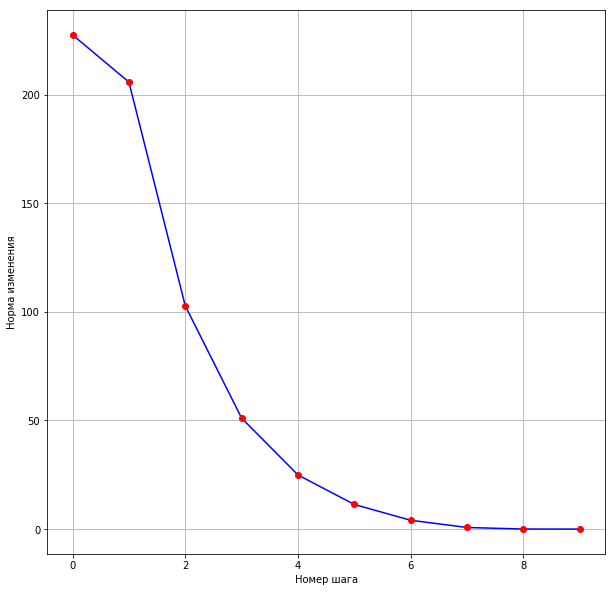


Error : 4.69524696683e-05


In [676]:
gpa = calc(path='gpa-4.txt', values=values_gpa['4'])

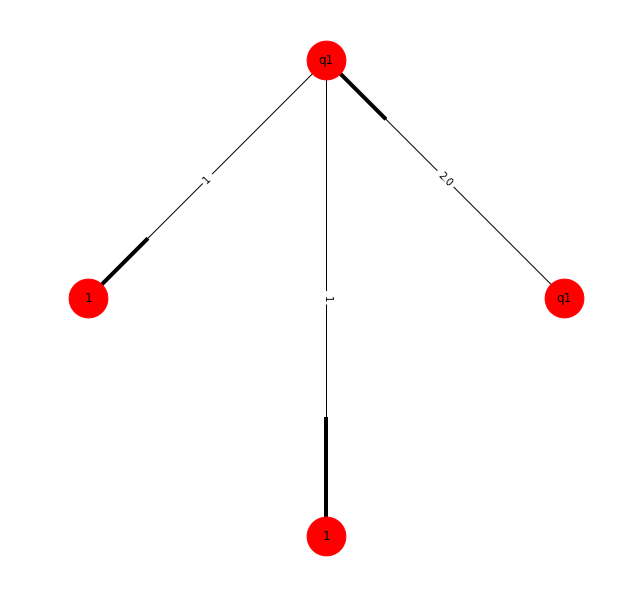

In [680]:
disp_graph_with_custom_labels(gr=gpa, edge_label='q', node_label='influx')

In [681]:
def get_AF_AL(A=None):
    AF = sm.zeros(A.shape[0], A.shape[1])
    AL = sm.zeros(A.shape[0], A.shape[1])

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            val = int(A[i, j])
            if val == 1:
                AF[i, j] = 1
            elif val == -1:
                AL[i, j] = 1

    AF_T = sm.Matrix(AF.T)
    AL_T = sm.Matrix(AL.T)
    
    return (AF, AL)

In [682]:
def phi(ps, pf, D, L):
    return (ps ** 2 - pf ** 2)

In [683]:
def get_edge_index(gr=None, edge=()):
    return list(gr.edges()).index(edge)

In [684]:
def get_edge_by_index(gr=None, index=0):
    return list(gr.edges())[index]

In [685]:
def get_node_by_index(gr=None, index=0):
    return gr.nodes[index]

In [686]:
def replace_cols(A=None, i=0, j=0):
    shape = A.shape
    
    A_copy = deepcopy(A)
    
    rows = shape[0]
    cols = shape[1]
    
    if i < cols and j < cols:
        A_copy[:, i] = A[:, j]
        A_copy[:, j] = A[:, i]
        
        return A_copy

In [687]:
def replace_rows(A=None, i=0, j=0):
    shape = A.shape
    
    A_copy = deepcopy(A)
    
    rows = shape[0]
    cols = shape[1]
    
    print(shape, i, j)
    
    if i < rows and j < rows:
        A_copy[j, :] = A[i, :]
        A_copy[i, :] = A[j, :]
        
        return A_copy

In [688]:
def set_cols_order(A=None, cols_order=[]):
    T = deepcopy(A)
    for pos, index in zip(cols_order, range(len(cols_order))):
        T[:, index] = A[:, pos]
        
    return T

In [689]:
def set_rows_order(A=None, rows_order=[]):
    T = deepcopy(A)
    for pos, index in zip(rows_order, range(len(rows_order))):
        T[index, :] = A[pos, :]
        
    return T

In [690]:
def get_all_matrix(gpa=None, phi=None):
    
    A = nx.incidence_matrix(G=gpa, 
                            oriented=True).todense()
    
    P = [ gpa.nodes[node]['var'] 
         for node in gpa.nodes() ]
    P = sm.Matrix(P)
    

#     known_edges = [ get_edge_index(gr=gpa, edge=edge) 
#                    for edge in gpa.edges() 
#                    if gpa.edges[edge]['known']]
#     unknown_edges = [ get_edge_index(gr=gpa, edge=edge) 
#                      for edge in gpa.edges() 
#                      if not gpa.edges[edge]['known']]
    
    known_nodes_q = [ node - 1 for node in gpa.nodes() 
                   if gpa.nodes[node]['known_q']]
    
    unknown_nodes_q = [ node - 1 for node in gpa.nodes() 
                     if not gpa.nodes[node]['known_q']]
    known_nodes_p = [ node - 1 for node in gpa.nodes() 
                   if gpa.nodes[node]['known']]
    unknown_nodes_p = [ node - 1 for node in gpa.nodes() 
                     if not gpa.nodes[node]['known']]
    knowledges_nodes = {
        'p':{
            'known' : known_nodes_p,
            'unknown' : unknown_nodes_p
        },
        'q':{
            'known' : known_nodes_q,
            'unknown' : unknown_nodes_q
        }
    }
    
    eq = []
    
    A_s = get_AF_AL(A=A)
    
    AF_T = sm.Matrix(A_s[0].T)
    AL_T = sm.Matrix(A_s[1].T)
    
    PF = AF_T * P
    PL = AL_T * P

    for pf, ps in zip(PF, PL):
        eq.append(phi(ps, pf, 1, 1))
        
    X = sm.Matrix(eq)
    
    d_F_i = []
    d_L_i = []

    diff_vars = []
    for edge_index, eq in zip(gpa.edges(), X):
        node_s = gpa.node[edge_index[0]]['var']
        node_f = gpa.node[edge_index[1]]['var']
        
        eq_s = sm.diff(eq, node_s)
        eq_f = -sm.diff(eq, node_f)
        
        d_F_i.append(eq_s)
        d_L_i.append(eq_f)
    
    d_F_i = sm.diag(*d_F_i)
    d_L_i = sm.diag(*d_L_i)
    
    return (A, X, (AF_T, AL_T), (d_F_i, d_L_i), P, knowledges_nodes)

In [691]:
def get_Q(gr=None):    
    Q = []
    for edge in gr.edges():
        Q.append(gr.edges[edge]['q'])
    
    return sm.Matrix(Q)

In [692]:
def get_P(gr=None):    
    P = []
    for node in gr.nodes():
        P.append(gr.nodes[node]['p'])
    
    return sm.Matrix(P)

In [700]:
gpa, syms = read_graph(path='gpa-4.txt')
res = get_all_matrix(gpa=gpa, phi=phi)

In [701]:
A = -1 * res[0]
X = res[1]
AF_T = res[2][0]
AL_T = res[2][1]
d_F = res[3][0]
d_L = res[3][1]
P = res[4]

In [702]:
nodes_p = res[5]['p']['known'] + res[5]['p']['unknown']
nodes_q = res[5]['q']['known'] + res[5]['q']['unknown']

In [696]:
A = set_cols_order(A, edges_order)
A = set_rows_order(A, nodes_order)

In [697]:
P = get_P(gr=gpa)
Q = get_Q(gr=gpa)

In [698]:
set_rows_order(A=P, rows_order=nodes_p)

Matrix([
[12],
[ 4],
[ 7],
[ 6],
[p2],
[p4]])

In [699]:
print(res[5])

{'p': {'known': [0, 2, 4, 5], 'unknown': [1, 3]}, 'q': {'known': [], 'unknown': [0, 1, 2, 3, 4, 5]}}
